In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import *
from tensorflow.keras.preprocessing.sequence import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as k
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split,StratifiedKFold
from tensorflow.keras.callbacks import *
from nltk.corpus import *
from nltk.stem import *
import string
from sklearn.preprocessing import *
from tqdm import tqdm

In [3]:
train_df=pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_df=pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample_sub=pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

In [4]:
#Load Word Embeddings
embedding_path='../input/glove840b300dtxt/glove.840B.300d.txt'
embedding_dict={}
embd_file=open(embedding_path,'r',errors = 'ignore',encoding='utf8')
for line in tqdm(embd_file):
    values=line.split(' ')
    word=values[0]
    coef=np.asarray(values[1:],dtype='float32')
    embedding_dict[word]=coef
embd_file.close()

2196018it [03:51, 9493.58it/s]


In [5]:
#Clean Text
sp=stopwords.words('english')
lm=WordNetLemmatizer()

def clean_text(df):
    #Remove punctuation
    print('Cleaning Punctuations')
    cleaned_text=[txt.translate(str.maketrans('','',string.punctuation)) for txt in df['excerpt']]

    print('Cleaning numbers')
    cleaned_text=[' '.join([i for i in txt.lower().split() if i.isalpha()]) for txt in cleaned_text]

    print('Cleaning Stopwords')
    cleaned_text=[' '.join(i for i in txt.split() if i not in sp) for txt in cleaned_text]
    
    #Normalize Word
    print('Word Normalizing')
    cleaned_text=[' '.join(lm.lemmatize(i) for i in txt.split()) for txt in cleaned_text]
    
    return cleaned_text

In [6]:
train_cleaned=clean_text(train_df)

Cleaning Punctuations
Cleaning numbers
Cleaning Stopwords
Word Normalizing


In [7]:
maxlen_=500
max_words=20000
print('Word Tokenization and Transforming')
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_cleaned)
sequences=tokenizer.texts_to_sequences(train_cleaned)
train_data_preped=pad_sequences(sequences,maxlen=maxlen_)
word_index=tokenizer.word_index
print('Tokenization Done!')

Word Tokenization and Transforming
Tokenization Done!


In [8]:
embedding_matrix=np.zeros((max_words,300))
print('Loading Embedding Matrix..\n')
for word,ix in tqdm(word_index.items()):
    if ix<max_words:
        embed_vec=embedding_dict.get(word)
        if embed_vec is not None:
            embedding_matrix[ix]=embed_vec

100%|██████████| 24535/24535 [00:00<00:00, 292606.17it/s]

Loading Embedding Matrix..



In [9]:
X_train,X_val,y_train,y_val=train_test_split(train_data_preped,train_df['target'],test_size=0.15)
print('Size of Train: ',X_train.shape)
print('Size of Validation: ',X_val.shape)

Size of Train:  (2408, 500)
Size of Validation:  (426, 500)


In [10]:
inp=Input(maxlen_)
x=Embedding(max_words,300)(inp)
x=Bidirectional(LSTM(256, return_sequences = True))(x)

#x = LSTM(256, return_sequences = True)(x)
#x = LSTM(256, return_sequences = True)(x)

#x = AveragePooling1D(pool_size = maxlen_)(x)

x=Conv1D(16,5,strides=2,padding='same')(x)
x=Activation('relu')(x)

x=Conv1D(32,3,strides=2,padding='same')(x)
x=Activation('relu')(x)

x=Conv1D(64,3,strides=4,padding='same')(x)
x=Activation('relu')(x)

x=Conv1D(128,3,strides=4,padding='same')(x)
x=Activation('relu')(x)

x=GRU(256)(x)
x=Dense(128,activation='relu')(x)
x = Dense(64, activation = 'relu')(x)
out=Dense(1)(x)
model=Model(inp,out)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 300)          6000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 512)          1140736   
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 16)           40976     
_________________________________________________________________
activation (Activation)      (None, 250, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 32)           1568      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 32)           0     

In [11]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=True

In [12]:
def rmse(y_true, y_pred):
        return k.sqrt(k.mean(k.square(y_pred - y_true))) 
    
model.compile(loss=rmse,optimizer=RMSprop(0.0001))
#Callbacks
rop = ReduceLROnPlateau(min_lr=0.000001,patience=2)
mc = ModelCheckpoint('model.h5',save_freq='epoch')
es = EarlyStopping(monitor='acc',patience=5,)

In [13]:
history=model.fit(X_train,y_train,batch_size=128,epochs=150,validation_data=(X_val,y_val),
                  callbacks=[mc,rop,es])

Epoch 1/150
19/19 [==============================] - 16s 320ms/step - loss: 1.2424 - val_loss: 0.9644
Epoch 2/150
19/19 [==============================] - 4s 237ms/step - loss: 0.8610 - val_loss: 0.8362
Epoch 3/150
19/19 [==============================] - 4s 237ms/step - loss: 0.7599 - val_loss: 0.7607
Epoch 4/150
19/19 [==============================] - 5s 240ms/step - loss: 0.7034 - val_loss: 0.7560
Epoch 5/150
19/19 [==============================] - 5s 244ms/step - loss: 0.6880 - val_loss: 0.7227
Epoch 6/150
19/19 [==============================] - 4s 236ms/step - loss: 0.6758 - val_loss: 0.7183
Epoch 7/150
19/19 [==============================] - 5s 238ms/step - loss: 0.6657 - val_loss: 0.7099
Epoch 8/150
19/19 [==============================] - 4s 237ms/step - loss: 0.6344 - val_loss: 0.7220
Epoch 9/150
19/19 [==============================] - 5s 239ms/step - loss: 0.6534 - val_loss: 0.7053
Epoch 10/150
19/19 [==============================] - 4s 234ms/step - loss: 0.6312 - val_l

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  import sys


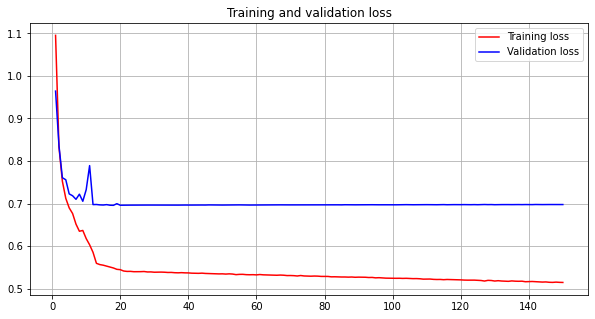

In [14]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'b', color='red', label='Training loss')
plt.plot(epochs, val_loss, 'b',color='blue', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()
plt.show()

In [15]:
cleaned_test=clean_text(test_df)

Cleaning Punctuations
Cleaning numbers
Cleaning Stopwords
Word Normalizing


In [16]:
print('Word Tokenization and Transforming of Test data')
tokenizer=Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(cleaned_test)
sequences=tokenizer.texts_to_sequences(cleaned_test)
test_data_preped=pad_sequences(sequences,maxlen=maxlen_)
word_index=tokenizer.word_index
print('Tokenization Done!')

Word Tokenization and Transforming of Test data
Tokenization Done!


In [17]:
model=load_model('model.h5',custom_objects={'rmse': rmse})
preds=model.predict(test_data_preped)
sample_sub['target']=preds
sample_sub.to_csv('submission.csv',index=False)